# Actividad 2: Análisis sintáctico
**Universidad Internacional de La Rioja (UNIR) - Máster Universitario en Inteligencia Artificial - Procesamiento del Lenguaje Natural**
***
**Datos de los alumnos (Nombres y Apellidos):**
    
&emsp;- César David Sáenz Salazar
    
&emsp;- Alvaro Pinto Mamani

*Fecha: 24/01/2023*
***

## Índice
* [1) Definición de librerias y funciones](#1)
* [2) Inicialización del las reglas sintácticas](#2)
* [3) Aplicación del algoritmo CKY](#3)

### 1. Definición de librerias y funciones<a class="anchor" id="1"></a>

In [37]:
from graphviz import Graph, Digraph, nohtml
from IPython.display import Image, display

'''
Clase para el objeto de cada regla seleccionada para la matriz
'''
class MatrixRule:
    # Función para inicializar el objeto
    def __init__(self, symbol, rule, origin, probability):
        self.symbol = symbol
        self.rule = rule
        self.origin = origin
        self.probability = probability

    # Función para obtener el simbolo de la regla
    def get_symbol(self):
        return self.symbol

    # Función para obtener el cuerpo de la regla
    def get_rule(self):
        return self.rule

    # Función para obtener las coordenadas del origen de la regla
    def get_origin(self):
        return self.origin

    # Función para obtener la probabilidad de la regla
    def get_probability(self):
        return self.probability

    # Función para obtener los datos de la regla completa
    def get_data(self):
        return self.symbol + ": " + str(self.rule) + " | Origen: " + str(self.origin) + " | Probabilidad: " + "%.2E" % self.probability


'''
Función que aplica el algoritmo CKY

Parámetros:
    * phrase:   Frase a análizar
    * grammar:  Gramatica con reglas a aplicar
'''
def algorithm_CKY(phrase, grammar):
    # Definición de la matriz para el algoritmo CKY
    len_words = len(phrase)
    matrix = [[[] for _ in range(len_words)] for _ in range(len_words)]

    # Análisis de la primer diagonal
    for n in range(len_words):
        for key, rules in grammar.items():
            for rule in rules:
                if phrase[n] in rule[1]:
                    # Si la palabra se encuentra en los elementos de la regla se guarda en la matriz
                    matrix[n][n].append(
                        MatrixRule(symbol=key, rule=rule[1], origin="-", probability=rule[0])
                    )

    # Análisis del resto de la matriz
    for n in range(1, len_words):
        for i in range(len_words - n):
            j = i + n
            for k in range(i, j):
                for key, rules in grammar.items():
                    for rule in rules:
                        for matrix_rule_1 in matrix[i][k]:
                            for matrix_rule_2 in matrix[k+1][j]:
                                symbol = matrix_rule_1.get_symbol() + " " + matrix_rule_2.get_symbol()
                                if symbol in rule[1]:
                                    # Si el simbolo existe en la combinación de las celdas de la matriz evaluadas se guarda un nuevo elemento en la matriz
                                    origin = ((i, k), (k+1, j))
                                    probability = rule[0] * matrix_rule_1.get_probability() * matrix_rule_2.get_probability()
                                    matrix[i][j].append(
                                        MatrixRule(symbol=key, rule=rule[1], origin=origin, probability=probability)
                                    )
    
    # Retorno del número de palabras y la matriz resultante
    return len_words, matrix


'''
Función para la construcción del árbol a gráficar

Parámetros:
    * matrix: Matríz resultado del algoritmo CKY con probabilidades
    * x: Fila
    * y: Columna
    * tree_list: Arreglo con los nodos padres e hijos
    * father: Parámetro para definir al padre, no se aplica en el primer nodo
    * rules: Parámetro que define la creación de nodos hijos en la función recursiva
    * root: Puntero de los nodos hijos
'''
def get_tree(matrix, x, y, tree_list = [], father = '', rules = '', root = 0):
    tree = []
    max = 0

    # Ciclo para encontrar el origen en la matríz resultado del algoritmo CKY, variante con probabilidades
    for m in matrix[x][y]:
        # Si existen reglas de entrada al nodo se define la posición que alimentará al nodo
        if(rules != ''):
            if isinstance(rules, str):
                rules = rules.split()

            for rule in rules:
                if(rule == m.get_symbol()):
                    max = m.get_probability()
                    if(len(tree) == 0):
                        tree.append(m)
        # Si no existen reglas de entrada se entiende que estamos por definir el primer nodo padre
        else:
            if(m.get_probability() > max):
                max = m.get_probability()
                # Sobreescribimos el primer nodo siempre que sea el primer nodo padre
                if(len(tree) == 0):
                    tree.append(m)
                else:
                    tree[0] = m
    
    if(len(tree) > 0):
        check = 0
        child = tree[0].get_symbol()
        
        # Definimos reglas para evitar nodos duplicados
        for el in tree_list:
            if(el['father'] == father and el['child'] == tree[0].get_symbol()):
                check = 1
            if(father == tree[0].get_symbol()):
                check = 1
            
        position = len(tree_list)
        probability = "%.2E" % tree[0].get_probability()

        if(check == 0):
            # Insertamos un nodo padre/hijo
            tree_list.append(
                {
                    'x': str(x),
                    'y': str(y),
                    'father': father,
                    'child': child,
                    'root': root,
                    'position': position,
                    'probability': probability,
                }
            )

        # Evaluamos si este tiene dependencia en la matríz, lo que creará nuevos nodos
        z = tree[0].get_origin()
        if(z != '-'):
            for k in z:
                # Mediante recursividad, obtenemos los nodos en base a la ruta de Viterbi
                get_tree(matrix, k[0], k[1], tree_list, tree[0].get_symbol(), tree[0].get_rule(), position)

    
    return tree_list


'''
Función para la graficación del árbol resultante de la matriz

Parámetros:
    * tree_list: Arreglo con los nodos padres e hijos
'''
def ploot_tree(tree_list):
    # Instancia de la librería de graficación de nodos graphviz
    g = Digraph('g', filename='btree.gv', node_attr={'shape': 'record', 'height': '.1'})
    
    # Ciclo para definir los nodos sin relaciones y/o punteros
    for i in range(len(tree_list)):
            # Imprimir nodos con probabilidad en una 4ta casilla
            g.node('node'+str(i), 
                nohtml('<f0> root:' + str(tree_list[i]['root']) + 
                        '|<f1> position:' + str(tree_list[i]['position']) + 
                        '|<f2>' + tree_list[i]['child']) + 
                        '|<f3> (' + tree_list[i]['x'] + ', ' + tree_list[i]['y'] + ')' + 
                        '|<f4> prob. ' + tree_list[i]['probability'])

    # Cliclo para definir los punteros en los nodos padres hacia los nodos hijos
    for i in range(len(tree_list)):
        if(tree_list[i]['father'] != ''):
            g.edge('node'+str(tree_list[i]['root'])+':f0', 'node'+str(tree_list[i]['position'])+':f1')

    # Visualización del ploot
    display(g)


'''
Función para la impresion de la matriz resultante y el árbol de la solución más óptima

Parámetros:
    * len_words: Número de palabras de la frase
    * matrix: Matriz final
'''
def print_matrix(len_words, matrix):
    # Impresión de la matriz resultante 
    for n in range(len_words):
        for i in range(len_words):
            if matrix[n][i]:
                print("\n(", n, ",", i, ")")
                for matrix_rule in matrix[n][i]:
                    print(matrix_rule.get_data())

    # Evaluación para determinar el resultado mas óptimo
    probability = 0
    optimal_solution = None
    for matrix_rule in matrix[0][len_words - 1]:
        if matrix_rule.get_symbol() == "S":
            if matrix_rule.get_probability() > probability:
                probability = matrix_rule.get_probability()
                optimal_solution = matrix_rule

    # Condición para determinar si hay una solución encontrada
    if optimal_solution == None:
        print("No hay solución para esta frase.")
    else:
        # Obtención del árbol con la ruta de Viterbi según el algoritmo CKY
        tree = get_tree(matrix, 0, len_words - 1)
        ploot_tree(tree)

### 2. Inicialización del las reglas sintácticas<a class="anchor" id="2"></a>

In [38]:
# Definición de la frase a análizar
phrase = "time flies like an arrow"
phrase = phrase.split()

# Definición de las reglas gramaticales
grammar = {
    "S": ((0.8, ('NP VP')),),
    "NP": ((0.002, ('time', 'flies', 'arrow')),
           (0.3, ('Det Nom')),
           (0.2, ('Nom Nom'))
           ),
    "Nom": ((0.002, ('time', 'flies', 'arrow')),
                (0.1, ('Nom Noun')),
                (0.2, ('Nom PP'))
                ),
    "VP": ((0.004, ('time')),
           (0.008, ('flies', 'like')),
           (0.3, ('Verb NP')),
           (0.2, ('Verb PP'))
           ),
    "PP": ((0.1, ('Prep NP')),),
    "Verb": ((0.01, ('time')),
             (0.02, ('flies', 'like'))
             ),
    "Noun": ((0.01, ('time', 'flies', 'arrow')),),
    "Det": ((0.05, ('an')),),
    "Prep": ((0.05, ('like')),),
}

### 3. Aplicación del algoritmo CKY<a class="anchor" id="3"></a>


( 0 , 0 )
NP: ('time', 'flies', 'arrow') | Origen: - | Probabilidad: 2.00E-03
Nom: ('time', 'flies', 'arrow') | Origen: - | Probabilidad: 2.00E-03
VP: time | Origen: - | Probabilidad: 4.00E-03
Verb: time | Origen: - | Probabilidad: 1.00E-02
Noun: ('time', 'flies', 'arrow') | Origen: - | Probabilidad: 1.00E-02

( 0 , 1 )
S: NP VP | Origen: ((0, 0), (1, 1)) | Probabilidad: 1.28E-05
NP: Nom Nom | Origen: ((0, 0), (1, 1)) | Probabilidad: 8.00E-07
Nom: Nom Noun | Origen: ((0, 0), (1, 1)) | Probabilidad: 2.00E-06
VP: Verb NP | Origen: ((0, 0), (1, 1)) | Probabilidad: 6.00E-06

( 0 , 2 )
S: NP VP | Origen: ((0, 1), (2, 2)) | Probabilidad: 5.12E-09

( 0 , 4 )
S: NP VP | Origen: ((0, 0), (1, 4)) | Probabilidad: 9.60E-13
NP: Nom Nom | Origen: ((0, 0), (1, 4)) | Probabilidad: 2.40E-14
S: NP VP | Origen: ((0, 1), (2, 4)) | Probabilidad: 1.15E-13
Nom: Nom PP | Origen: ((0, 1), (2, 4)) | Probabilidad: 6.00E-14

( 1 , 1 )
NP: ('time', 'flies', 'arrow') | Origen: - | Probabilidad: 2.00E-03
Nom: ('tim

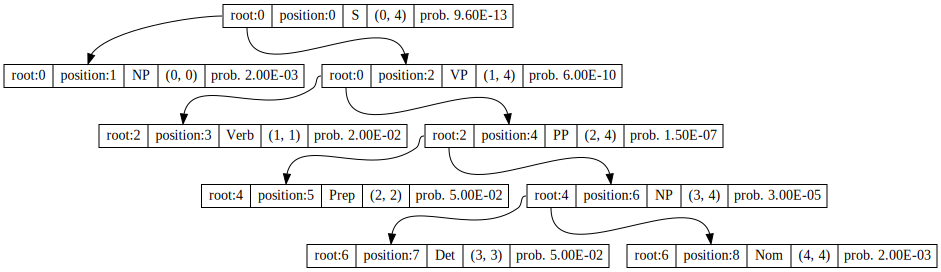

['time', 'flies', 'like', 'an', 'arrow']


In [39]:
len_words, matrix = algorithm_CKY(phrase, grammar)
print_matrix(len_words, matrix)
print(phrase)